# Predicting Seizures: current Kaggle project

Kaggle, a popular machine learning website, has recently began a competition requesting the prediction of seizures given timeseries data for epilepsy patients. More can be read about the particular project at [this website](https://www.kaggle.com/c/melbourne-university-seizure-prediction) where a description of the data is also provided.

I believe this project provides a great platform to test out the hadoop/theano framework at Vanderbilt given the emense date set provided on these medical patients. Training data is supplied for three patients where observational data per patient exceeds 5.5 Gb for the training sets and 6+ Gb for testing data.

The main scientific problems I wish to address using these campus resources are based on the intersection of astrophysics and artificial intelligence, my main research focus. For example, the [Gaia Experiment](http://sci.esa.int/gaia/) recently released astrophysical data on over 1 billion stars. One current idea is the calculation of a two-point correlation function of stellar positions, an operation that is $O(n^2)$ in complexity. Another possible application is in the detection of extra solar planets (planets orbitting nearby stars that are not the sun).

Below, I outline a hypothesis in approaching the Kaggle problem, outlining the need for robust computational resources and in the process, also describing the typical format of the data and magnitude of it.

The main hypothesis outlined in this notebook is the **Density of states** methods.


The density of states idea relies on one hypothesis, that being that the electrode measurements sample enough of the possible states of the system $g(s)$, such that the partition function can be written as:


$$
Z(t) = \int_s ds ~ g(s, t) \approx \sum_k f_k(t),
$$

where the index $k$ counts over what samples we have of the system at time $t$. In this case, any physical observable $O(t)$, can be approximately sampled over the ensemble as follows:

$$
O(t) \approx \frac{\sum_k O_k(t) f_k(t)}{\sum_k f_k(t)}.
$$

The trick here is to find an appropriate observable $O(t)$ such that it captures a precursor to the seizure state. My hypothesis is to test an appropriate measure to capture the statistical state of a two-state system. As a first step, I would like to test the following definition:

$$
O(t) \equiv I(t)^{(p)} = \frac{f(t)^{(p)}_S - f(t)^{(p)}_N}{f(t)^{(p)}_S + f(t)^{(p)}_N}
$$

where $f(t)^{(p)}_S$ is an "averaged" seizure state voltage trained over the seizured state data set for a given electrode $p$, and $f(t)^{(p)}_N$ is similiary defined. A first stab at defining these functions may be:

$$
f(t)^{(p)} = \frac{1}{M} \sum_m f(t)^{(p)}_m
$$

where m is an index that sums over all of the known state wave forms at a given time for each state, per electrode. It is not clear whether or not one should treat each electrode separately, hence I will treat each separately for now and continue to build these two functions from our available data below.

## Constructing the learned functions: $~~f(t)^{~(p)}_S$ and $~~f(t)^{~(p)}_N$ 

In the following code, I construct the two functions from known data, but first, I wish to find out how long it takes to load just one file on my laptop at a reasonable sample rate.

The function that constructs our training functions is as follows:

In [40]:
def construct_learned_functions(sample_rate, verbose = False):
    
    file_dir = '/Users/richard/data/seizure_data/train_1/test/'

    col_names = ["electrode_%s" % x for x in range(1,17)]

    test_filename = file_dir + '../1_1_0.mat'
    total_measurements = mat_pandas(test_filename, col_names, 1).shape[0]

    list_seizure     = gb.glob(file_dir + '1_*_1.mat')
    list_non_seizure = gb.glob(file_dir + '1_*_0.mat')

    down_sample_rate = sample_rate
    N_samples        = int(total_measurements / down_sample_rate) 
    N_electrodes     = 16

    f_S = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)
    f_N = pd.DataFrame(np.zeros((N_samples, N_electrodes)), columns=col_names)

    if verbose == True:
        print('Seizure test file list length is:     %s' %len(list_seizure))
        print('Non-seizure test file list length is: %s\n' %len(list_seizure))

        print('This is out of a possible full training set (for just one patient) of: ')
        print('Seizure test file list length is:     %s'   %len(gb.glob(file_dir + '../1_*_1.mat')))
        print('Non-seizure test file list length is: %s\n' %len(gb.glob(file_dir + '../1_*_0.mat')))
        
        print('A typical file has the structure: \n')
        print(mat_pandas(test_filename, col_names, 1).head())
        print('')
        print('with dimension %s' %str(mat_pandas(test_filename, col_names, 1).shape))


    # This is the heavy computation section:
    
    for filename in list_non_seizure:

        f_N += mat_pandas(filename, col_names, down_sample_rate)
    
    for filename in list_seizure:

        f_S += mat_pandas(filename, col_names, down_sample_rate)

    f_N = f_N/len(list_non_seizure)
    f_S = f_S/len(list_seizure)
    
    return f_N, f_S


This function is a computationally intense calculation. We need to do a sum over all training files to produce a matrix that averages over all training sets, and that's even considering a considerable down-sample. We can time it using the jupyter magic function %timeit, which runs the function given three times and returns the best time:

In [30]:
%timeit construct_learned_functions(10000, False)

1 loop, best of 3: 4 s per loop


Not too bad, but for 1,000s of files, the calculation time becomes quickly intractable. We can run this function with verbose = True to see some more information regarding the data structure:

In [43]:
f_N, f_S = construct_learned_functions(1, True)

Seizure test file list length is:     10
Non-seizure test file list length is: 10

This is out of a possible full training set (for just one patient) of: 
Seizure test file list length is:     150
Non-seizure test file list length is: 1152

A typical file has the structure: 

   electrode_1  electrode_2  electrode_3  electrode_4  electrode_5  \
0     3.275756    24.066677   -54.997391    -3.789555   -19.482683   
1     1.275756    20.066677   -64.997391    -2.789555   -22.482683   
2     4.275756    16.066677   -63.997391     3.210445   -26.482683   
3     5.275756    13.066677   -58.997391     7.210445   -28.482683   
4    -3.724244    12.066677   -51.997391     6.210445   -23.482683   

   electrode_6  electrode_7  electrode_8  electrode_9  electrode_10  \
0   -21.098763      6.14821   -14.256918   -17.065411     72.938507   
1   -21.098763      7.14821   -17.256918   -14.065411     80.938507   
2   -20.098763      5.14821   -17.256918   -15.065411     78.938507   
3   -19.098763    

And, also plot the seizured and non-seizured data set for one electrode (electrode 2):

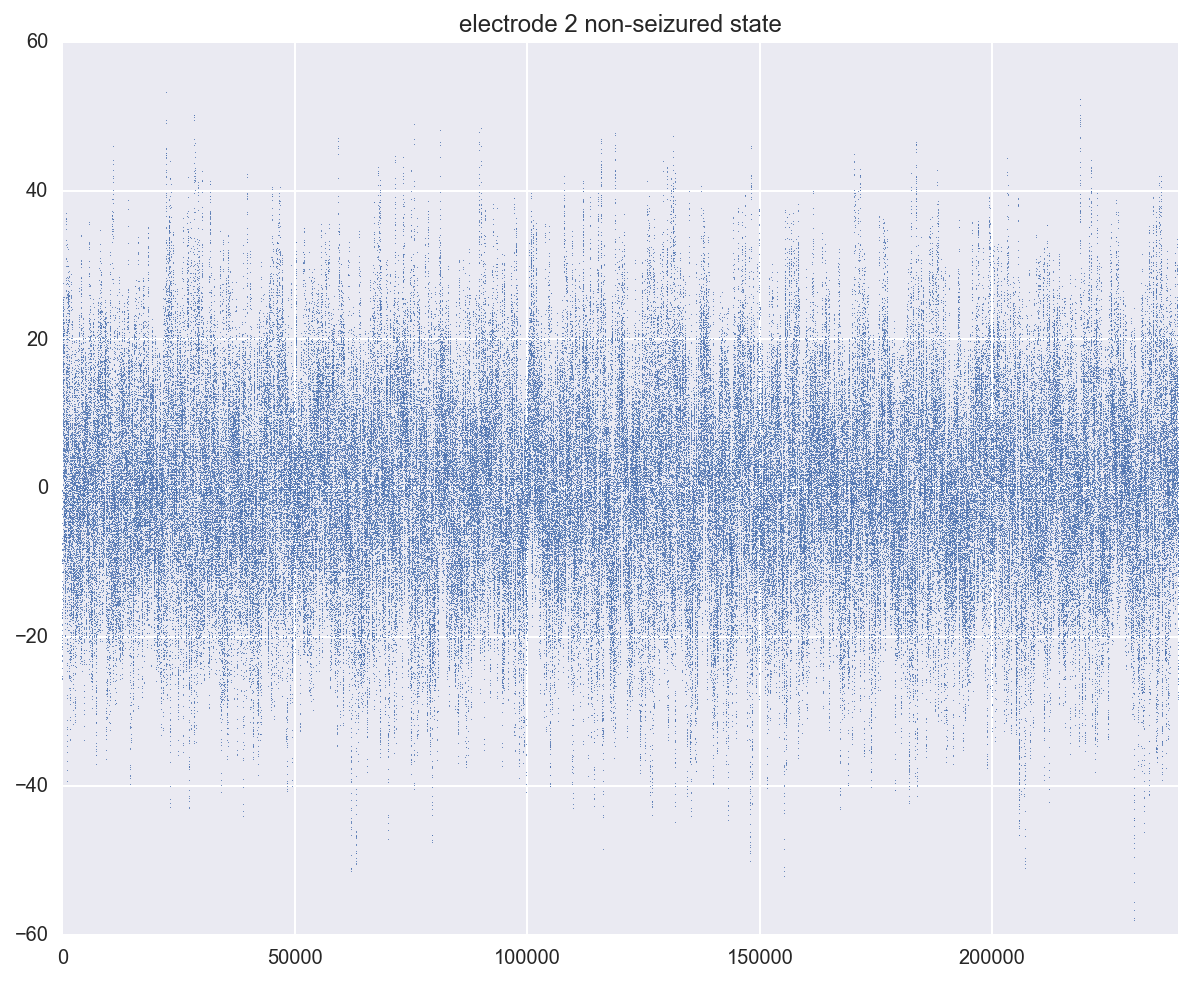

In [67]:
f_N['electrode_2'].plot(style='.', markersize=1, figsize=(10,8), title = 'electrode 2 non-seizured state');

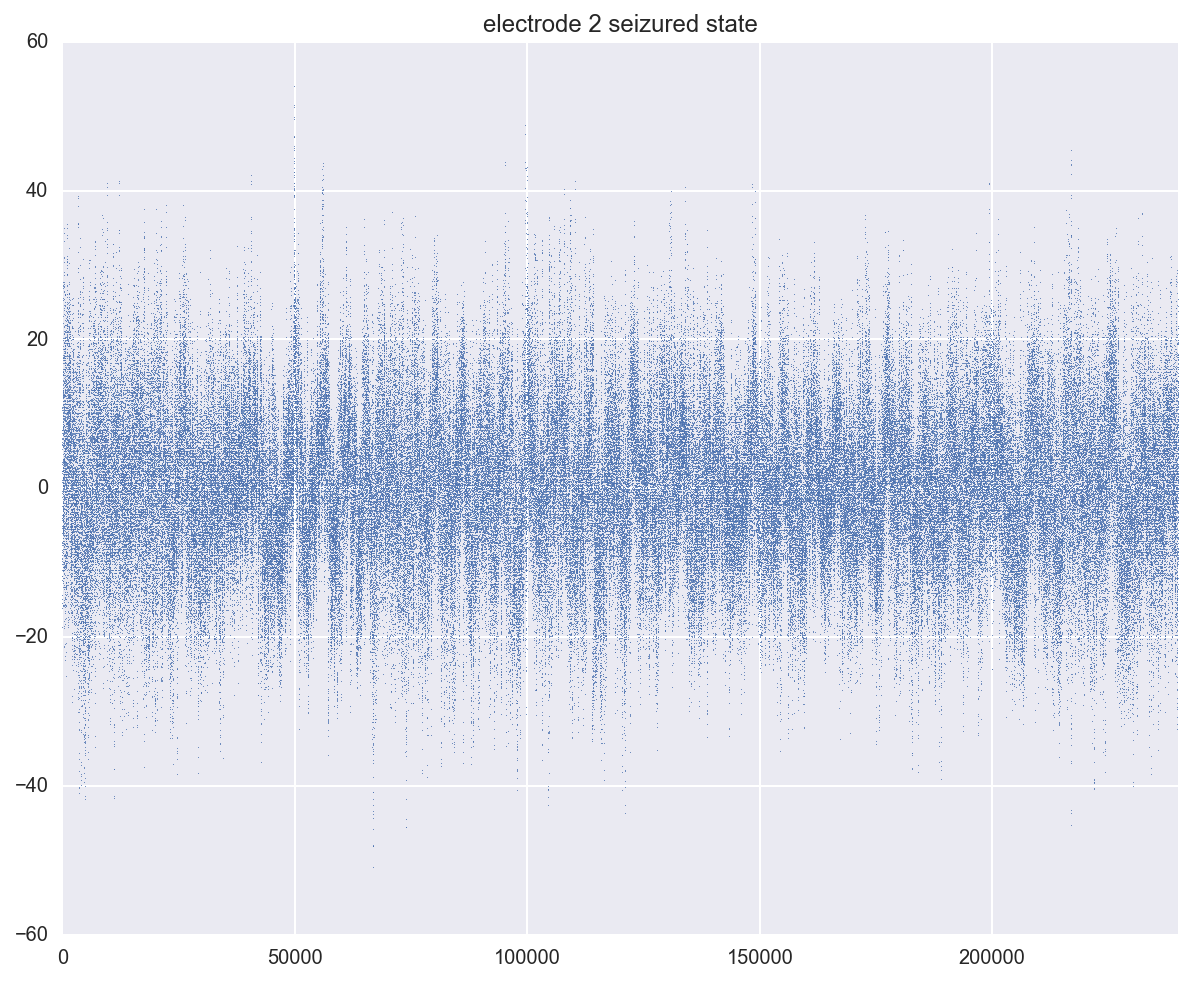

In [66]:
f_S['electrode_2'].plot(style='.', markersize=1, figsize=(10,8), title = 'electrode 2 seizured state');

In [53]:
#data = [go.Scatter(x = f_N['electrode_2'].index , y = f_N['electrode_2'])]
#layout = go.Layout(title = 'averaged electrode 2 signal for non-seizure data', xaxis = dict( title='time samples 400 Hz') )
#fig = dict(data=data, layout=layout)
#py.iplot(fig)

#data = [go.Scatter(x = f_S['electrode_2'].index , y = f_S['electrode_2'])]
#layout = go.Layout(title = 'averaged electrode 2 signal for seizure data', xaxis = dict( title='time samples 400 Hz') )
#fig = dict(data=data, layout=layout)
#py.iplot(fig)

In [52]:
#helper function to load matlab files and return pandas dataframes
def mat_pandas(file_name, col_names, down_sample):

    data = sio.loadmat(file_name)
    mdata = data['dataStruct']
    mtype = mdata.dtype
    ndata = {n: mdata[n][0,0] for n in mtype.names}
    data_raw = ndata['data']
    data_raw = data_raw[::down_sample, :]
    df = pd.DataFrame(data_raw,columns=col_names)

    del data
    
    return df

In [54]:
import pandas as pd
import numpy as np
import scipy.io as sio
import plotly.offline as py
import plotly.graph_objs as go
import glob as gb

py.offline.init_notebook_mode()
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')